# Vegetation at the Strabrechtse Heide

Applying online learnings on a topic and natural area close to Eindhoven.

Based on: https://github.com/planetlabs/notebooks/tree/scipy-2022/jupyter-notebooks/scipy-2022-workshop

In [2]:
from glob import glob

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

%matplotlib inline

In [3]:
def compose_scene():
    """
    Extracts red, green, and blue bands
    
    Returns:
    --------
        band_red :   Array[int]
                     Red band image.
        band_green : Array[int]
                     Green band image.
        band_blue :  Array[int]
                     Blue band image.
    """

    # Extract visual imagery
    with rasterio.open('heide/B2_20.TIF') as src:
        band_blue = src.read(1)
    with rasterio.open('heide/B3_20.TIF') as src:
        band_green = src.read(1)
    with rasterio.open('heide/B4_20.TIF') as src:
        band_red = src.read(1)
        # Inladen NIR band
    with rasterio.open('heide/B5_20.TIF') as src:
        band_nir = src.read(1) 

#     Stacking bands for full image
    visual_image = np.dstack((band_blue, band_green, band_red))

    return band_blue, band_green, band_red,band_nir, visual_image

In [4]:
# Extract visual images
band_blue, band_green, band_red, band_nir, visual_image = compose_scene()

## Colored picture 

Text(0.5, 1.0, '2018 visual image')

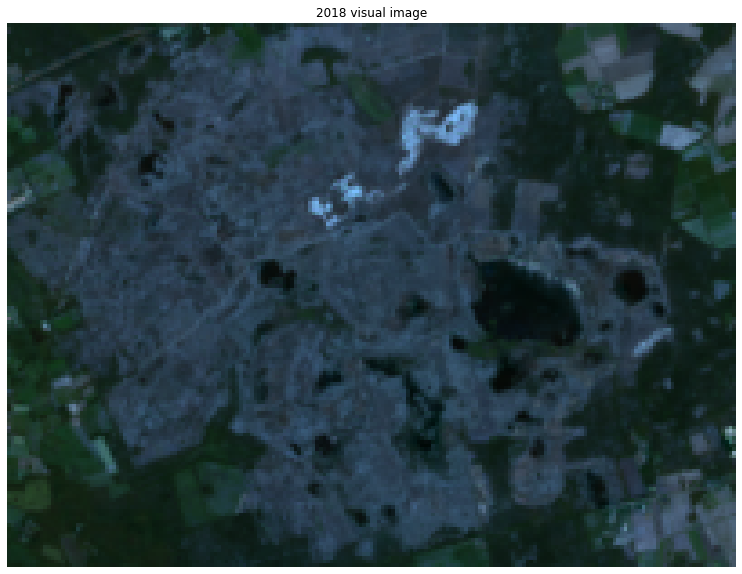

In [5]:
plt.figure(figsize=(30,10))
# plt.imshow((visual_image/69).astype(np.uint8))
plt.imshow(((visual_image - visual_image.min()) / (visual_image.max() - visual_image.min())*255).astype(np.uint8))
plt.axis('off')
plt.title("2018 visual image")

## Normalized difference water index (NDWI)

In [6]:
def measure_ndwi(band_green, band_nir):
    """
    Normalized difference water index (NDWI).
 
    """

    # delen door 0 toestaan
    np.seterr(divide='ignore', invalid='ignore')

    # NDWI
    ndwi = (band_green.astype(float) - band_nir.astype(float)) / (band_green +
                                                                  band_nir)

    return ndwi

In [7]:
# NDWI Water index
ndwi = measure_ndwi(band_green, band_nir)

Text(0.5, 1.0, '2018 NDWI Values')

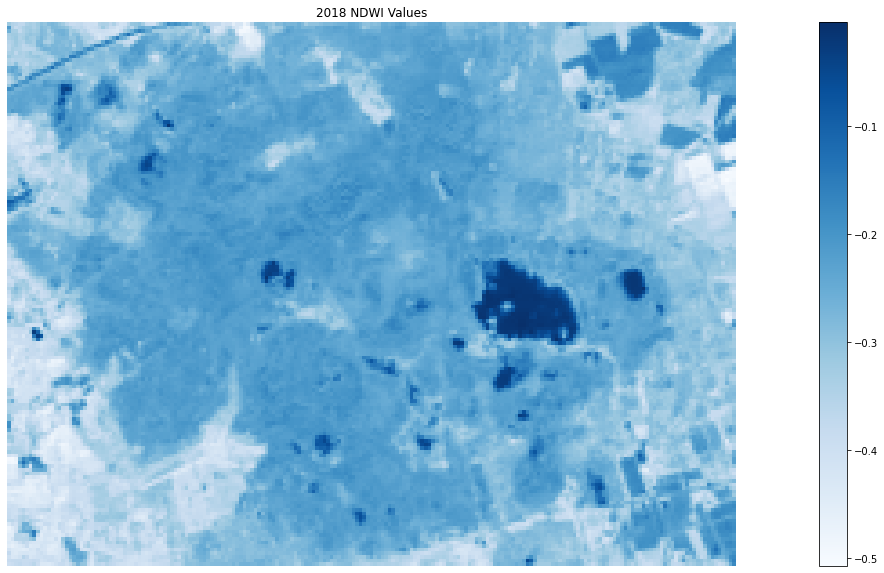

In [8]:
plt.figure(figsize=(30,10))
fig = plt.imshow(ndwi)
fig.set_cmap('Blues')
# fig.set_cmap('viridis')
plt.axis('off')
plt.colorbar()
plt.title("2018 NDWI Values")

In [9]:
# Inladen rode band
with rasterio.open('heide/B4_22.TIF') as src:
    band_red = src.read(1)
    
# Inladen NIR band
with rasterio.open('heide/B5_22.TIF') as src:
    band_nir = src.read(1)    

In [10]:
band_red.shape

(150, 201)

In [11]:
band_nir.shape

(150, 201)

In [12]:
def measure_ndvi(band_red, band_nir):
    """
    Normalized difference vegetation index (NDVI) berekenen.

    Parameters:
    -----------
        band_red : Array[int]
               Normalized red band image.
        band_nir : Array[int]
               Normalized NIR band image.
    
    Returns:
    --------
        ndvi : Array[float]
               Normalized difference water index.    
    """

    # delen door 0 toestaan vanwege onderstaande berekening
    np.seterr(divide='ignore', invalid='ignore')

    # NDVI berekenen
    ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir.astype(float) + band_red.astype(float))

    return ndvi

In [13]:
ndvi = measure_ndvi(band_red,band_nir)

Text(0.5, 1.0, '2022 NDVI Values')

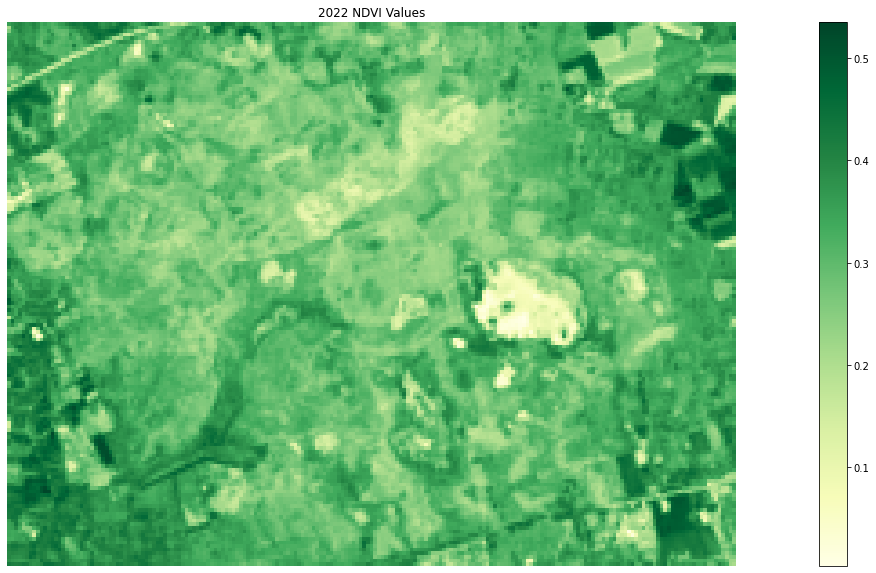

In [14]:
plt.figure(figsize=(30,10))
fig = plt.imshow(ndvi)
# fig.set_cmap('Blues')
fig.set_cmap('YlGn')
plt.axis('off')
plt.colorbar()
plt.title("2022 NDVI Values")

## (Modified) Soil Adjusted Vegetation Index (SAVI)

In [15]:
def measure_savi(band_red, band_nir):
    """
    (Modified) Soil Adjusted Vegetation Index (SAVI) berekenen.

    Parameters:
    -----------
        band_red : Array[int]
               Normalized red band image.
        band_nir : Array[int]
               Normalized NIR band image.
    
    Returns:
    --------
        savi : Array[float]
               Soil Adjusted Vegetation Index    
    """

    # delen door 0 toestaan vanwege onderstaande berekening
    np.seterr(divide='ignore', invalid='ignore')

    # SAVI berekenen
    # savi = ((band_nir.astype(float) - band_red.astype(float)) / (band_nir.astype(float) + band_red.astype(float) + 0.5)) * 1.5

    # optioneel: Modified Soil Adjusted Vegetation Index (MSAVI)
    savi = (band_nir.astype(float) + 0.5 - (0.5 * np.sqrt((2 * band_nir.astype(float) + 1)**2 - 8 * (band_nir.astype(float) - (2 * band_red.astype(float)))))) + 0.4    
    return savi

In [16]:
savi = measure_savi(band_red,band_nir)

Text(0.5, 1.0, '2022 SAVI Values')

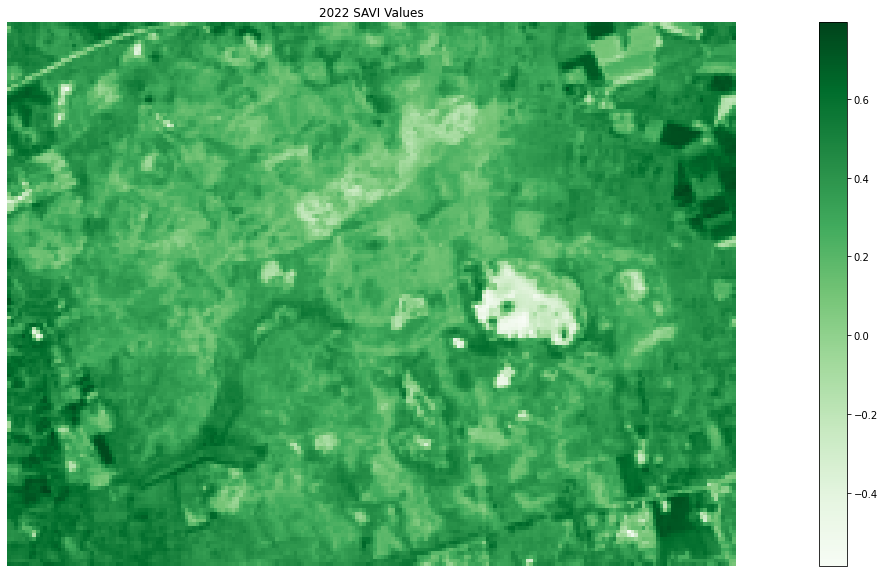

In [17]:
plt.figure(figsize=(30,10))
fig = plt.imshow(savi)
# fig.set_cmap('Blues')
fig.set_cmap('Greens')
plt.axis('off')
plt.colorbar()
plt.title("2022 SAVI Values")

## identify green and create mask

In [18]:
def green_fill(b4,b5):
    
    # Extract the red band
    with rasterio.open(b4) as src:
        band_red = src.read(1)

    # Extract the NIR band
    with rasterio.open(b5) as src:
        band_nir = src.read(1)   
                       
    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Calculate NDWI
#     ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir.astype(float) + band_red.astype(float))
#     savi = ((band_nir.astype(float) - band_red.astype(float)) / (band_nir.astype(float) + band_red.astype(float) + 0.5)) * 1.5
    savi = (band_nir.astype(float) + 0.5 - (0.5 * np.sqrt((2 * band_nir.astype(float) + 1)**2 - 8 * (band_nir.astype(float) - (2 * band_red.astype(float)))))) + 0.4    

    print(savi.shape)
                       
    GREEN_THRESHOLD = 0.4
    green_mask = np.full(savi.shape, np.nan)
    # Threshold the SAVI image
    green_mask[savi >= GREEN_THRESHOLD] = 1
                       
    return green_mask

In [19]:
green_mask22 = green_fill('heide/B4_22.TIF','heide/B5_22.TIF')

(150, 201)


Text(0.5, 1.0, '2022 green mask')

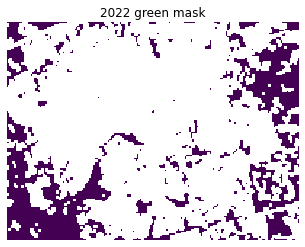

In [20]:
plt.figure(0)
plt.imshow(green_mask22)
plt.axis('off')
plt.title("2022 green mask")

In [21]:
green_mask20 = green_fill('heide/B4_20.TIF','heide/B5_20.TIF')

(150, 201)


Text(0.5, 1.0, '2020 green mask')

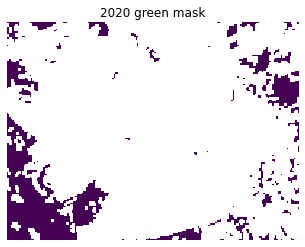

In [22]:
plt.figure(0)
plt.imshow(green_mask20)
plt.axis('off')
plt.title("2020 green mask")

In [23]:
green_mask18 = green_fill('heide/B4_18.TIF','heide/B5_18.TIF')

(150, 201)


Text(0.5, 1.0, '2018 green mask')

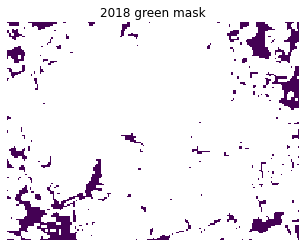

In [24]:
plt.figure(0)
plt.imshow(green_mask18)
plt.axis('off')
plt.title("2018 green mask")

## comparison vegetation and non vegetation between two years

In [25]:
diff_mask_22_20 = np.nan_to_num(green_mask22) - np.nan_to_num(green_mask20)

Text(0.5, 1.0, 'difference')

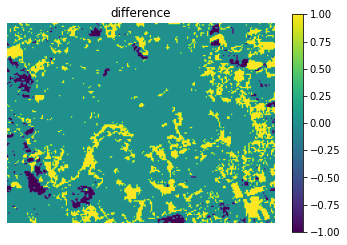

In [26]:
plt.figure(0)
plt.imshow(diff_mask_22_20)
plt.axis('off')
plt.colorbar()
plt.title("difference")

In [27]:
diff_mask_20_18 = np.nan_to_num(green_mask20) - np.nan_to_num(green_mask18)

Text(0.5, 1.0, 'difference')

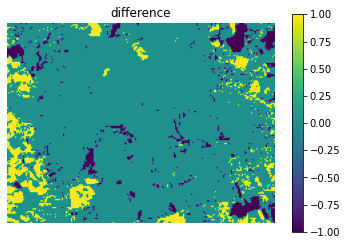

In [28]:
plt.figure(0)
plt.imshow(diff_mask_20_18)
plt.axis('off')
plt.colorbar()
plt.title("difference")

In [29]:
np.nansum(green_mask18)

np.float64(5048.0)

In [30]:
files = [green_mask18,green_mask20,green_mask22]

## count green pixels

In [31]:
sums = []

In [32]:
for i in files:
    tot = np.nansum(i)
    sums.append(tot)

In [33]:
sums

[np.float64(5048.0), np.float64(5870.0), np.float64(9930.0)]

## Counting number of green pixels and plotting them 

([<matplotlib.axis.XTick at 0x7f9acba742e0>,
 [Text(0, 0, '18'), Text(1, 0, '20'), Text(2, 0, '22')])

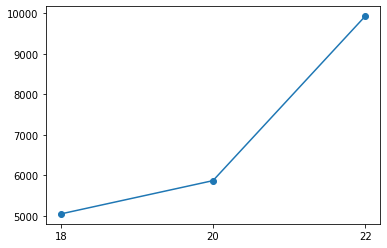

In [34]:
plt.plot(sums,'o-')
plt.xticks([0,1,2], ['18', '20', '22'])